# VGG(使用块的网络)

## VGG介绍

1. AlexNet比LeNet更深更大，那我要是继续更深更大呢？故他有更多的全连接层，更多的卷积层。
2. 提出了**VGG块：即3\*3卷积（填充1），可以放置n层m个通道，最后放一个2\*2最大池化层，步幅2**
 - **这样的操作会使得图像宽高各自减半，故一般经历一个VGG块会增加一倍通道数**
 - 为什么此处选择3\*3而不是5\*5：**因为窄而深远比宽而浅更好！**
 - 这个思想后续沿用，即使用重复的卷积块来构建深度网络。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 实现VGG块

In [2]:
def vgg_block(num_covs, in_channels, out_channels):# 等价于做了通道重整，图像大小不变化，直到进入池化
  layers = []
  for _ in range(num_covs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。

第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。

由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

### 实现VGG网络

疑问解答：
- in_channels是1,是因为用的数据集fashion_mnist的图片都是灰度图。
- 7\*7是因为原图是224\*224。经历了5次/2之后变为7*7


In [4]:
def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  for (num_covs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_covs, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(*conv_blks, nn.Flatten(), nn.Linear(7 * 7 * out_channels, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))# 此处本来是1000，但此处图片为10类

In [5]:
net = vgg(conv_arch).cuda()
X = torch.randn(size=(1, 1, 224, 224),device='cuda:0')
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。将通道数都减半。

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch).cuda()

### 训练

In [7]:
batch_size =128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224);

In [8]:
for i, (X, y) in enumerate(train_iter):
  print(X.shape)
  print(y.shape)
  break

torch.Size([128, 1, 224, 224])
torch.Size([128])


In [9]:
def train(net, train_iter, test_iter, num_epochs, lr): #此函数d2l.torch库中本身就有，但我们需要熟悉函数逻辑，这是后面深度学习中最常见的代码
    """用GPU训练模型(此处不需要，因为上面已经将net与X转到GPU中了)，模型使用SGD，损失函数是交叉熵"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.cuda(), y.cuda() #训练集的数据移动到device上
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

loss 0.171, train acc 0.937, test acc 0.921
2774.6 examples/sec


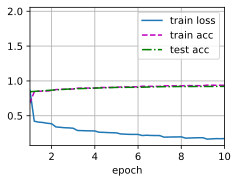

In [10]:
lr, num_epochs= 0.05, 10
train(net, train_iter, test_iter, num_epochs, lr)